In [42]:
import torch
import ever as er
from torchange.models.changen2 import s1_init_s1c1_changestar_vitb_1x256
from torchange.models.changen2 import s9_init_s9c1_changestar_vitb_1x256
from skimage.io import imread
import albumentations as A
import albumentations.pytorch
import matplotlib.pyplot as plt
import numpy as np
torch.set_grad_enabled(False)

**s1_init_s1c1_changestar_vitb_1x256** is a zero-shot building change detection model.

In [26]:
model = s1_init_s1c1_changestar_vitb_1x256()
model.eval()
model.to(er.auto_device())

2025-07-17 12:29:10, INFO:EVER:Load Changen2 pre-trained weight from EVER-Z/Changen2-ChangeStar1x256/s1c1_cstar_vitb_1x256.pth
2025-07-17 12:29:10, INFO:EVER:architecture: changestar_1x256 | backbone: vitb | pre-trained data: Changen2-S1-15k


ChangeStar1xd(
  (encoder): SAMEncoderFarSeg(
    (vit): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
          (drop_path): Identity()
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1

In [22]:
img1 = imread('https://raw.githubusercontent.com/Z-Zheng/pytorch-change-models/main/demo_images/t1_img.png')
img2 = imread('https://raw.githubusercontent.com/Z-Zheng/pytorch-change-models/main/demo_images/t2_img.png')
img1.shape, img2.shape

((1024, 1024, 3), (1024, 1024, 3))

In [8]:
preprocess = A.Compose([
    A.Normalize(),
    A.pytorch.ToTensorV2()
], additional_targets={'image2': 'image'})

In [23]:
data = preprocess(image=img1, image2=img2)
img = torch.concat([data['image'], data['image2']], dim=0)  # (2 c) h w
img.shape

torch.Size([6, 1024, 1024])

In [27]:
prediction = model(img.unsqueeze(0).to(er.auto_device()))

In [28]:
prediction.keys()

dict_keys(['change_prediction', 't1_semantic_prediction', 't2_semantic_prediction'])

In [29]:
prediction = er.to.to_device(prediction, torch.device('cpu'))

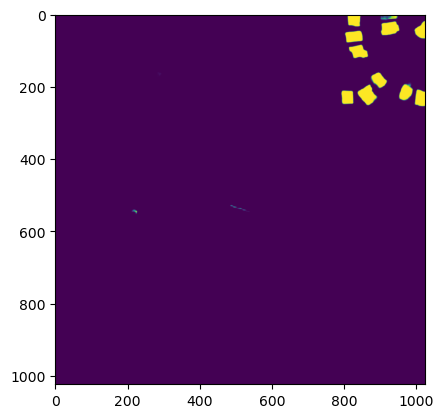

In [32]:
plt.imshow(prediction['change_prediction'].squeeze().numpy())

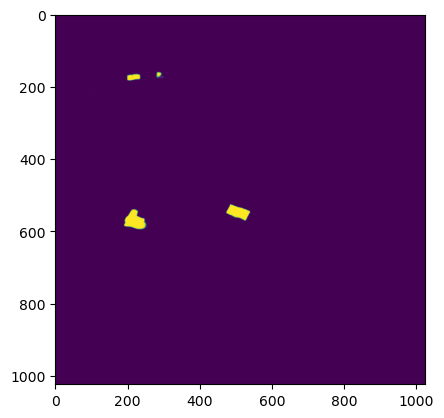

In [33]:
plt.imshow(prediction['t1_semantic_prediction'].squeeze().numpy())

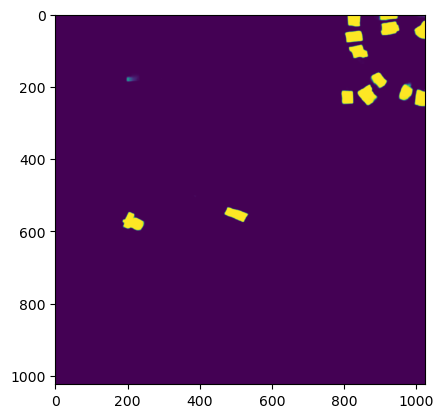

In [34]:
plt.imshow(prediction['t2_semantic_prediction'].squeeze().numpy())

**s9_init_s9c1_changestar_vitb_1x256** is a zero-shot land cover change detection model, where Unknow = 0, Bareland = 1, Rangeland = 2, DevelopedSpace = 3, Road = 4, Tree = 5, Water = 6, AgricultureLand = 7, Building = 8. This model can predict two semantic segmentation maps (9 classes) and a binary change map that captures the transitions between the above nine classes.



In [37]:
model_s9c1 = s9_init_s9c1_changestar_vitb_1x256()
model_s9c1.eval()
model_s9c1.to(er.auto_device())

2025-07-17 12:34:18, INFO:EVER:Load Changen2 pre-trained weight from EVER-Z/Changen2-ChangeStar1x256/s9c1_cstar_vitb_1x256.pth
2025-07-17 12:34:18, INFO:EVER:architecture: changestar_1x256 | backbone: vitb | pre-trained data: Changen2-S9-27k


ChangeStar1xd(
  (encoder): SAMEncoderFarSeg(
    (vit): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
          (drop_path): Identity()
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1

In [38]:
prediction = model_s9c1(img.unsqueeze(0).to(er.auto_device()))

In [39]:
prediction.keys()

dict_keys(['change_prediction', 't1_semantic_prediction', 't2_semantic_prediction'])

In [40]:
prediction = er.to.to_device(prediction, torch.device('cpu'))

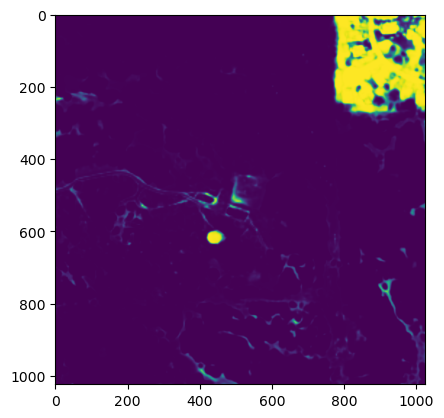

In [41]:
plt.imshow(prediction['change_prediction'].squeeze().numpy())

In [43]:
CMAP = np.array(
    [[0, 0, 0],
     [128, 0, 0],  # Bareland
     [0, 255, 36],  # Rangeland
     [148, 148, 148],  # Developed space
     [255, 255, 255],  # Road
     [34, 97, 38],  # Tree
     [0, 69, 255],  # Water
     [75, 181, 73],  # Agriculture land
     [222, 31, 7]],  # Building
    dtype=np.uint8
)

In [44]:
t1_semantic_prediction = prediction['t1_semantic_prediction'].argmax(dim=1)
t2_semantic_prediction = prediction['t2_semantic_prediction'].argmax(dim=1)
t1_semantic_prediction.shape, t2_semantic_prediction.shape

(torch.Size([1, 1024, 1024]), torch.Size([1, 1024, 1024]))

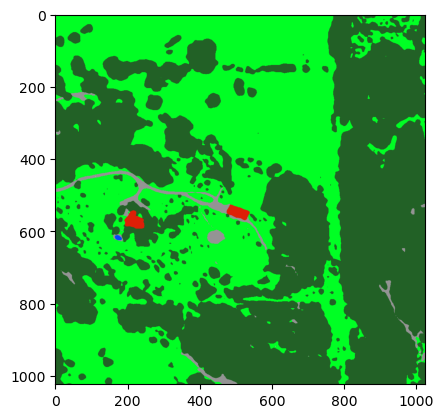

In [46]:
plt.imshow(CMAP[t1_semantic_prediction.squeeze().numpy()])

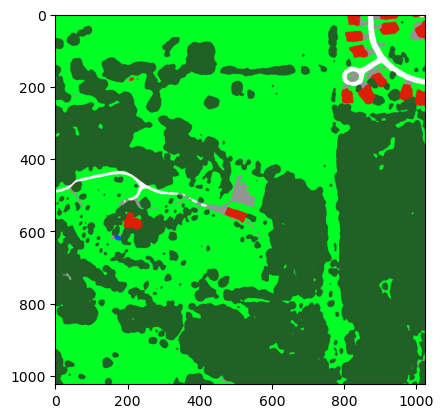

In [47]:
plt.imshow(CMAP[t2_semantic_prediction.squeeze().numpy()])